<a href="https://colab.research.google.com/github/ZaUt-bio/SincNet-used-for-Parkinsons-Disease-detection/blob/main/Model_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# type 2 of introducing of configs
config = {
    'windowing': {
        'fs': 512,
        'cw_len': 500,
        'cw_shift': 5
    },
    'cnn': {
        'cnn_N_filt': '100,64,128',
        'cnn_len_filt': '257,20,10',
        'cnn_max_pool_len': '1,5,2',
        'cnn_use_laynorm_inp': 'False',
        'cnn_use_batchnorm_inp': 'False',
        'cnn_use_laynorm': 'False,False,False,False',
        'cnn_use_batchnorm': 'False,False,False,False',
        'cnn_act':  'leaky_relu,leaky_relu,leaky_relu',
        'cnn_drop': '0.0,0.0,0.0,0.0'
    },
    'dnn': {
        'fc_lay': '1024',
        'fc_drop': '0.25,0.0',
        'fc_use_laynorm_inp': 'False',
        'fc_use_batchnorm_inp': 'False',
        'fc_use_batchnorm': 'False,False',
        'fc_use_laynorm': 'False,False',
        'fc_act': 'leaky_relu,relu'
    },
    'class': {
        'class_lay': '1',
        'class_drop': '0.0',
        'class_use_laynorm_inp': 'False',
        'class_use_batchnorm_inp': 'False',
        'class_use_batchnorm': 'False',
        'class_use_laynorm': 'False',
        'class_act': 'sigmoid' #'softmax'
    },
    'optimization': {
        'lr': '0.0001',
        'batch_size': '47',
        'N_epochs': '10',
        'N_batches': '30',
        'N_eval_epoch': '1',
        'seed': '1234'
    }
}
INP_dim = 512
fs = int(512)
fold = 9

# base of the code

## 2. data_io

In [ ]:
# removed functions: read_conf & read_conf_inp & create_batches_rnd
import configparser as ConfigParser
from optparse import OptionParser
import numpy as np
import scipy
import torch


def ReadList(list_file):
    f = open(list_file, "r")
    lines = f.readlines()
    list_sig = []
    for x in lines:
        list_sig.append(x.rstrip())
    f.close()
    return list_sig



def str_to_bool(s):
    print(s)
    if s == 'True':
        return True
    elif s == 'False':
        return False
    else:
        raise ValueError



## flip and sinc functions

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import math


def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.contiguous()
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, -1, -1),
                                                  ('cpu', 'cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)


def sinc(band, t_right):
    y_right = torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
    y_left = flip(y_right, 0)

    y = torch.cat([y_left, Variable(torch.ones(1)).cuda(), y_right])

    return y

## SincConv_fast

In [ ]:

class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters for EEG-based emotion recognition
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 500.
    Usage
    -----
    See `torch.nn.Conv2d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=512, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=0.01, min_band_hz=10):

        super(SincConv_fast, self).__init__()

        if in_channels != 1:
            # msg = (f'SincConv only support one input channel '
            #       f'(here, in_channels = {in_channels:d}).')
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (
                  in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size+1

        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in
        # Mel scale around the complete range of the pre-filtered EEG trial
        low_hz = 0.5
        high_hz = 50 # according to the preprocessing high_low frequencies
        #print(out_channels)
        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)

        hz = self.to_hz(mel)

        self.hz = hz # این در کل مارونلی نیستش

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))
        # our learnable parameter within neural network model
        # setting the Hamming window
        # computing only half of the window
        n_lin = torch.linspace(0, (self.kernel_size/2)-1,
                               steps=int((self.kernel_size/2)))
        self.window_ = 0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size)
        n = (self.kernel_size - 1) / 2.0
        # Due to symmetry, I only need half of the time axes
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate

    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.
        """

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz + torch.abs(self.low_hz_)

        high = torch.clamp(low + self.min_band_hz +
                           torch.abs(self.band_hz_), self.min_low_hz, self.sample_rate/2)
        band = (high-low)[:, 0]

        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET).
        # I just have expanded the sinc and simplified the terms. This way I avoid several useless computations (Mirco).
        band_pass_left = ((torch.sin(f_times_t_high) -
                           torch.sin(f_times_t_low))/(self.n_/2))*self.window_
        band_pass_center = 2*band.view(-1, 1)
        band_pass_right = torch.flip(band_pass_left, dims=[1])

        band_pass = torch.cat(
            [band_pass_left, band_pass_center, band_pass_right], dim=1)

        band_pass = band_pass / (2*band[:, None])

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                        bias=None, groups=1)



## act_fun and LayerNorm

In [ ]:

def act_fun(act_type):
    """activation function selection function
    Parameters for any type of Conv/DNN layer
    act_type: str
         activation function name, and correlate this with all the possible activation functions in Pytorch
    """
    if act_type == "relu":
        return nn.ReLU()

    if act_type == "tanh":
        return nn.Tanh()

    if act_type == "sigmoid":
        return nn.Sigmoid()

    if act_type == "leaky_relu":
        return nn.LeakyReLU(0.2)

    if act_type == "elu":
        return nn.ELU()

    if act_type == "gelu":
        return nn.GELU()

    if act_type == "softmax":
        return nn.LogSoftmax(dim=1)

    if act_type == "linear":
        # initializzed like this, but not used in forward!
        return nn.LeakyReLU(1)
    if act_type == "swish":
        return nn.SiLU()
    if act_type == "hardswish":
        return nn.Hardswish()


class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta



## MLP

In [ ]:

class MLP(nn.Module):
    """
    MLP/DNN layer constructor [dnn/fc] option values from the cfg file are parsed here
    """
    def __init__(self, options):
        super(MLP, self).__init__()

        self.input_dim = int(options['input_dim'])
        self.fc_lay = options['fc_lay']
        self.fc_drop = options['fc_drop']
        self.fc_use_batchnorm = options['fc_use_batchnorm']
        self.fc_use_laynorm = options['fc_use_laynorm']
        self.fc_use_laynorm_inp = options['fc_use_laynorm_inp']
        self.fc_use_batchnorm_inp = options['fc_use_batchnorm_inp']
        self.fc_act = options['fc_act']

        self.wx = nn.ModuleList([])
        self.bn = nn.ModuleList([])
        self.ln = nn.ModuleList([])
        self.act = nn.ModuleList([])
        self.drop = nn.ModuleList([])

        # input layer normalization
        if self.fc_use_laynorm_inp:
            self.ln0 = LayerNorm(self.input_dim)

        # input batch normalization
        if self.fc_use_batchnorm_inp:
            self.bn0 = nn.BatchNorm1d([self.input_dim], momentum=0.05)

        self.N_fc_lay = len(self.fc_lay)

        current_input = self.input_dim

        # Initialization of hidden layers

        for i in range(self.N_fc_lay):

            #print('شماره حلقه :', i)
            # dropout
            self.drop.append(nn.Dropout(p=self.fc_drop[i]))

            # activation
            self.act.append(act_fun(self.fc_act[i]))

            add_bias = True

            # layer norm initialization
            self.ln.append(LayerNorm(self.fc_lay[i]))
            self.bn.append(nn.BatchNorm1d(self.fc_lay[i], momentum=0.05))

            if self.fc_use_laynorm[i] or self.fc_use_batchnorm[i]:
                add_bias = False

            # Linear operations
            self.wx.append(
                nn.Linear(current_input, self.fc_lay[i], bias=add_bias))

            # weight initialization
            self.wx[i].weight = torch.nn.Parameter(torch.Tensor(self.fc_lay[i], current_input).uniform_(
                -np.sqrt(0.01/(current_input+self.fc_lay[i])), np.sqrt(0.01/(current_input+self.fc_lay[i]))))
            self.wx[i].bias = torch.nn.Parameter(torch.zeros(self.fc_lay[i]))

            current_input = self.fc_lay[i]

    def forward(self, x):

        # Applying Layer/Batch Norm
        if bool(self.fc_use_laynorm_inp):
            x = self.ln0((x))

        if bool(self.fc_use_batchnorm_inp):
            x = self.bn0((x))

        for i in range(self.N_fc_lay):

            if self.fc_act[i] != 'linear':

                if self.fc_use_laynorm[i]:
                    x = self.drop[i](self.act[i](self.ln[i](self.wx[i](x))))

                if self.fc_use_batchnorm[i]:
                    x = self.drop[i](self.act[i](self.bn[i](self.wx[i](x))))

                if self.fc_use_batchnorm[i] is False and self.fc_use_laynorm[i] is False:
                    #print('x.shapeبرای فوروارد', x.shape)
                    #print('self.wx[i]',self.wx[i])
                    #print('self.act[i](self.wx[i](x))',(self.act[i](self.wx[i](x))).shape)
                    x = self.drop[i](self.act[i](self.wx[i](x)))

            else:
                if self.fc_use_laynorm[i]:
                    x = self.drop[i](self.ln[i](self.wx[i](x)))

                if self.fc_use_batchnorm[i]:
                    x = self.drop[i](self.bn[i](self.wx[i](x)))

                if self.fc_use_batchnorm[i] is False and self.fc_use_laynorm[i] is False:
                    x = self.drop[i](self.wx[i](x))

        return x



## SincNet

In [ ]:
class SincNet(nn.Module):
    """
    full SincNet constructor all option-values from the cfg file are parsed here
    """
    def __init__(self, options):
        super(SincNet, self).__init__()

        self.cnn_N_filt = options['cnn_N_filt']
        self.cnn_len_filt = options['cnn_len_filt']
        self.cnn_max_pool_len = options['cnn_max_pool_len']

        self.cnn_act = options['cnn_act']
        self.cnn_drop = options['cnn_drop']

        self.cnn_use_laynorm = options['cnn_use_laynorm']
        self.cnn_use_batchnorm = options['cnn_use_batchnorm']
        self.cnn_use_laynorm_inp = options['cnn_use_laynorm_inp']
        self.cnn_use_batchnorm_inp = options['cnn_use_batchnorm_inp']

        self.input_dim = int(options['input_dim'])

        self.fs = options['fs']

        self.N_cnn_lay = len(options['cnn_N_filt'])
        self.conv = nn.ModuleList([])
        self.bn = nn.ModuleList([])
        self.ln = nn.ModuleList([])
        self.act = nn.ModuleList([])
        self.drop = nn.ModuleList([])

        if self.cnn_use_laynorm_inp:
            self.ln0 = LayerNorm(self.input_dim)
        #else:
         #   self.ln.append(0)

        if self.cnn_use_batchnorm_inp:
            self.bn0 = nn.BatchNorm1d([self.input_dim], momentum=0.05)

        current_input = INP_dim #self.input_dim

        for i in range(self.N_cnn_lay):

            N_filt = int(self.cnn_N_filt[i])
            #len_filt = int(self.cnn_len_filt[i])# این اصن استافده نشده

            # dropout
            self.drop.append(nn.Dropout(p=self.cnn_drop[i]))

            # activation
            self.act.append(act_fun(self.cnn_act[i]))
            # layer norm initialization

            self.ln.append(LayerNorm(
                [N_filt, int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])]))# or 1???

            self.bn.append(nn.BatchNorm1d(N_filt, int(
                (current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i]), momentum=0.05))# or 1???


            if i == 0:

                self.conv.append(SincConv_fast(
                    self.cnn_N_filt[0], self.cnn_len_filt[0], self.fs))
            else:
                #self.conv.append(nn.Conv2d(self.cnn_N_filt[i-1], self.cnn_N_filt[i], [
                #                self.cnn_len_filt[i][0], self.cnn_len_filt[i][1]]))

                self.conv.append(nn.Conv1d(self.cnn_N_filt[i-1], self.cnn_N_filt[i], self.cnn_len_filt[i]))


            current_input = int(
                (current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])
            print('**current_input shape: {} and N_filt.shape: {}'.format(current_input,N_filt))



        self.out_dim = current_input*N_filt
        print('**current_input shape: {} and N_filt.shape: {}'.format(current_input,N_filt))


    def forward(self, x):
        batch = x.shape[0]
        seq_len = x.shape[1]

        if bool(self.cnn_use_laynorm_inp):
            x = self.ln0((x))

        if bool(self.cnn_use_batchnorm_inp):
            x = self.bn0((x))

        x = x.view(batch, 1, seq_len)
        for i in range(self.N_cnn_lay):
            #boogh = self.conv[i](x)

            if self.cnn_use_laynorm[i]:
                if i == 0:
                    x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(
                        torch.abs(self.conv[i](x)), self.cnn_max_pool_len[i]))))
                else:
                    x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(self.conv[i](
                        x), self.cnn_max_pool_len[i]))))

            if self.cnn_use_batchnorm[i]:
                x = self.drop[i](self.act[i](self.bn[i](F.max_pool1d(self.conv[i](
                    x), self.cnn_max_pool_len[i]))))

            if self.cnn_use_batchnorm[i] is False and self.cnn_use_laynorm[i] is False:
                x = self.drop[i](self.act[i](F.max_pool1d(self.conv[i](
                    x), self.cnn_max_pool_len[i])))


        x = x.view(batch, -1)

        return x

# Import your dataset


In [ ]:
# خودشه
# دادگان با پیش پردازش جدید =))) Hoooray
def overlapping_win(signal,fs=512,window_length = 2,overlaping_shift = 0.5):
  # 75% overlapping windows
  i = 0
  while 1:
    if i==0:
      windowed_sig = signal[0,0:window_length*fs]
    else:
      windowed_sig = np.vstack((windowed_sig,signal[0,0+int(i*overlaping_shift*fs):int(window_length*fs+(i*overlaping_shift*fs))]))
    i = i+1
    if (window_length*fs+(i)*overlaping_shift*fs) >= signal.shape[1]:
      break
  return windowed_sig
# ************
import os.path as op
import os
!pip3 install mne
import mne
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
for hc_pd in [0,1]:
    address = []
    a = 0
    if hc_pd == 0:
        # it is healthy case
        for number in [1,2,4,7,8,10,18,20,21,24,25,29,30,31,32,33]:
            #********** 16 healthy
            a = a+1
            address = f'/content/drive/My Drive/COLAB/project/dataset/hc_{number}_final.set'
            file_name = f'hc_{a}'
            globals()['hc%s' % a] = mne.io.read_raw_eeglab(address)
            #globals()['hc%s_Oz' % a] = globals()['hc%s' % a].copy().pick(['Oz']).get_data()
            #globals()['hc%s_P8' % a] = globals()['hc%s' % a].copy().pick(['P8']).get_data()
            #globals()['hc%s_FC2' % a] = globals()['hc%s' % a].copy().pick(['FC2']).get_data()
            if a == 1:
              hc_Oz = globals()['hc%s' % a].copy().pick(['Oz']).get_data()
              hc_Oz = overlapping_win(hc_Oz)

            else:

              hc_Oz = np.vstack((hc_Oz, overlapping_win(globals()['hc%s' % a].copy().pick(['Oz']).get_data())))


    else:
        for number in [3,5,6,9,11,12,13,14,16,17,19,22,23,26,28]:
            #********** 15 PD
            a = a+1
            address = f'/content/drive/My Drive/COLAB/project/dataset/pd_{number}_off_final.set'
            file_name = f'pd_{a}'
            globals()['pd%s' % a] = mne.io.read_raw_eeglab(address)
            #globals()['pd%s_Oz' % a] = globals()['pd%s' % a].copy().pick(['Oz']).get_data()
            #globals()['pd%s_P8' % a] = globals()['pd%s' % a].copy().pick(['P8']).get_data()
            #globals()['pd%s_FC2' % a] = globals()['pd%s' % a].copy().pick(['FC2']).get_data()
            if a == 1:
              pd_Oz = globals()['pd%s' % a].copy().pick(['Oz']).get_data()
              pd_Oz = overlapping_win(pd_Oz)
            else:
              pd_Oz = np.vstack((pd_Oz, overlapping_win(globals()['pd%s' % a].copy().pick(['Oz']).get_data())))

clear_output()

print('pd_Oz is {} epochs with overlaping windows' .format(pd_Oz.shape))
print('hc_Oz is {} epochs with overlaping windows' .format(hc_Oz.shape))
# phase 2:
X_Oz = np.vstack([pd_Oz,hc_Oz])
X_Oz = np.squeeze(X_Oz)
Y = np.concatenate((np.ones(len(pd_Oz)),np.zeros(len(hc_Oz))))
# Min-MAx Scalling
scaler = MinMaxScaler()
model = scaler.fit(X_Oz)
X_Oz_MinMax = model.transform(X_Oz)
# چون ایندکس داده های ترین و تست قراره از فولدها دربیاد این بخش زیر هش شد
#train_data, test_data, train_labels, test_labels = train_test_split(X_Oz_MinMax, Y, test_size=0.1, random_state=1234, stratify=Y)
#print('For training we chose 90% of epochs that is {} epochs in general' .format(train_data.shape[0]))

pd_Oz is (4387, 1024) epochs with overlaping windows
hc_Oz is (4556, 1024) epochs with overlaping windows


# Creation of models

In [ ]:
# این نمونه کد بالاست که با کانفیگ ها ست شده بوده
# myself
# let me see if this class which we made it up here works?
#
import numpy as np
from numpy import genfromtxt
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
import torch
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = '0,1'
#data_folder = config['data']['data_folder']

# [windowing] section
INP_dim = 512
fs = int(512)
# [cnn] section
cnn_N_filt = list(map(int, config['cnn']['cnn_N_filt'].split(',')))
cnn_len_filt = list(map(int, config['cnn']['cnn_len_filt'].split(',')))
cnn_max_pool_len = list(map(int, config['cnn']['cnn_max_pool_len'].split(',')))
cnn_use_laynorm_inp = str_to_bool(config['cnn']['cnn_use_laynorm_inp'])
cnn_use_batchnorm_inp = str_to_bool(config['cnn']['cnn_use_batchnorm_inp'])
cnn_use_laynorm = list(map(str_to_bool, config['cnn']['cnn_use_laynorm'].split(',')))
cnn_use_batchnorm = list(
    map(str_to_bool, config['cnn']['cnn_use_batchnorm'].split(',')))
cnn_act = list(map(str, config['cnn']['cnn_act'].split(',')))
cnn_drop = list(map(float, config['cnn']['cnn_drop'].split(',')))

# [dnn] section
fc_lay = list(map(int, config['dnn']['fc_lay'].split(',')))
fc_drop = list(map(float, config['dnn']['fc_drop'].split(',')))
fc_use_laynorm_inp = str_to_bool(config['dnn']['fc_use_laynorm_inp'])
fc_use_batchnorm_inp = str_to_bool(config['dnn']['fc_use_batchnorm_inp'])
fc_use_batchnorm = list(
    map(str_to_bool, config['dnn']['fc_use_batchnorm'].split(',')))
fc_use_laynorm = list(
    map(str_to_bool, config['dnn']['fc_use_laynorm'].split(',')))
fc_act = list(map(str, config['dnn']['fc_act'].split(',')))

# [class] section
class_lay = list(map(int, config['class']['class_lay'].split(',')))
class_drop = list(map(float, config['class']['class_drop'].split(',')))
class_use_laynorm_inp = str_to_bool(config['class']['class_use_laynorm_inp'])
class_use_batchnorm_inp = str_to_bool(config['class']['class_use_batchnorm_inp'])
class_use_batchnorm = list(
    map(str_to_bool, config['class']['class_use_batchnorm'].split(',')))
class_use_laynorm = list(
    map(str_to_bool, config['class']['class_use_laynorm'].split(',')))
class_act = list(map(str, config['class']['class_act'].split(',')))

# [optimization] section
lr = float(config['optimization']['lr'])
batch_size = int(config['optimization']['batch_size'])
N_epochs = int(config['optimization']['N_epochs'])
N_batches = int(config['optimization']['N_batches'])
N_eval_epoch = int(config['optimization']['N_eval_epoch'])
seed = int(config['optimization']['seed'])

# loss function
#cost = nn.NLLLoss() ==> is applied only on models with the softmax function as an output activation layer.
cost = nn.BCELoss()


#------------------
# Reading cfg file you added as input from the command call
#options = read_conf()
#print(options)

#
CNN_arch = {'input_dim': INP_dim,
            'fs': fs,
            'cnn_N_filt': cnn_N_filt,
            'cnn_len_filt': cnn_len_filt,
            'cnn_max_pool_len': cnn_max_pool_len,
            'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
            'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
            'cnn_use_laynorm': cnn_use_laynorm,
            'cnn_use_batchnorm': cnn_use_batchnorm,
            'cnn_act': cnn_act,
            'cnn_drop': cnn_drop,
            }

CNN_net = SincNet(CNN_arch)
DNN1_arch = {'input_dim': CNN_net.out_dim,
             'fc_lay': fc_lay,
             'fc_drop': fc_drop,
             'fc_use_batchnorm': fc_use_batchnorm,
             'fc_use_laynorm': fc_use_laynorm,
             'fc_use_laynorm_inp': fc_use_laynorm_inp,
             'fc_use_batchnorm_inp': fc_use_batchnorm_inp,
             'fc_act': fc_act,
             }

DNN1_net = MLP(DNN1_arch)
DNN2_arch = {'input_dim': fc_lay[-1],
             'fc_lay': class_lay,
             'fc_drop': class_drop,
             'fc_use_batchnorm': class_use_batchnorm,
             'fc_use_laynorm': class_use_laynorm,
             'fc_use_laynorm_inp': class_use_laynorm_inp,
             'fc_use_batchnorm_inp': class_use_batchnorm_inp,
             'fc_act': class_act,
             }


DNN2_net = MLP(DNN2_arch)


False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
**current_input shape: 256 and N_filt.shape: 100
**current_input shape: 47 and N_filt.shape: 64
**current_input shape: 19 and N_filt.shape: 128
**current_input shape: 19 and N_filt.shape: 128


In [ ]:
print(CNN_net)
print(DNN1_net)
print(DNN2_net)

SincNet(
  (conv): ModuleList(
    (0): SincConv_fast()
    (1): Conv1d(100, 64, kernel_size=(20,), stride=(1,))
    (2): Conv1d(64, 128, kernel_size=(10,), stride=(1,))
  )
  (bn): ModuleList(
    (0): BatchNorm1d(100, eps=256, momentum=0.05, affine=True, track_running_stats=True)
    (1): BatchNorm1d(64, eps=47, momentum=0.05, affine=True, track_running_stats=True)
    (2): BatchNorm1d(128, eps=19, momentum=0.05, affine=True, track_running_stats=True)
  )
  (ln): ModuleList(
    (0-2): 3 x LayerNorm()
  )
  (act): ModuleList(
    (0-2): 3 x LeakyReLU(negative_slope=0.2)
  )
  (drop): ModuleList(
    (0-2): 3 x Dropout(p=0.0, inplace=False)
  )
)
MLP(
  (wx): ModuleList(
    (0): Linear(in_features=2432, out_features=1024, bias=True)
  )
  (bn): ModuleList(
    (0): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
  )
  (ln): ModuleList(
    (0): LayerNorm()
  )
  (act): ModuleList(
    (0): LeakyReLU(negative_slope=0.2)
  )
  (drop): ModuleList(
    

In [ ]:
## using a learning rate ten times greater for the SincConv and the ConvPool
## stage in comparison wit the rest of the architecture
# مارونلی rmsprop گذاشته
pt_file = '/content/drive/My Drive/COLAB/project/Network_weights/model_file_fold'+str(fold)+'.pkl'
#pt_file = 'none'
if pt_file != 'none': # اگر بخوای از وزن های ذخیره شده استافده کنی از نان درش بیار
    checkpoint_load = torch.load(pt_file)
    CNN_net.load_state_dict(checkpoint_load['CNN_model_par'])
    DNN1_net.load_state_dict(checkpoint_load['DNN1_model_par'])
    DNN2_net.load_state_dict(checkpoint_load['DNN2_model_par'])

optimizer_CNN = optim.Adam(
    CNN_net.parameters(), lr=lr*10, eps=1e-8)
optimizer_DNN1 = optim.Adam(DNN1_net.parameters(), lr=lr,  eps=1e-8)
optimizer_DNN2 = optim.Adam(DNN2_net.parameters(), lr=lr,  eps=1e-8)


# Training the model

In [ ]:
from sklearn.model_selection import KFold
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
import pandas as pd

In [ ]:
# با شروع کار این بخش نباید به هیچوجه مجدد ران شود تا فولد ها ثابت باقی بمانند
'''

from sklearn.model_selection import KFold
num_folds = 10
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
for fold,(train_indices, val_indices) in enumerate(kfold.split(X_Oz,Y)):
  print(fold)
  print(train_indices.shape)
  print(train_indices)
  #print(val_indices)
  np.savetxt('/content/drive/My Drive/COLAB/project/Network_folds/'+'fold'+str(fold)+'_train_indices'+'.txt', train_indices,fmt='%d')
  np.savetxt('/content/drive/My Drive/COLAB/project/Network_folds/'+'fold'+str(fold)+'_val_indices'+'.txt', val_indices,fmt='%d')

'''

0
(8048,)
[   0    1    2 ... 8939 8940 8942]
1
(8048,)
[   1    2    3 ... 8940 8941 8942]
2
(8048,)
[   0    1    2 ... 8939 8940 8941]
3
(8049,)
[   0    1    2 ... 8940 8941 8942]
4
(8049,)
[   0    1    2 ... 8940 8941 8942]
5
(8049,)
[   0    1    2 ... 8940 8941 8942]
6
(8049,)
[   0    1    2 ... 8940 8941 8942]
7
(8049,)
[   0    2    3 ... 8939 8941 8942]
8
(8049,)
[   0    1    3 ... 8940 8941 8942]
9
(8049,)
[   0    1    2 ... 8940 8941 8942]


In [ ]:
# fold = 0 ==> DONE
fold = 9


file_path = '/content/drive/MyDrive/COLAB/project/Network_folds/fold'+str(fold)+'_train_indices.txt'
train_indices = np.loadtxt(file_path,dtype=int)
file_path = '/content/drive/MyDrive/COLAB/project/Network_folds/fold'+str(fold)+'_val_indices.txt'
val_indices = np.loadtxt(file_path,dtype=int)
print(train_indices)
train_data = X_Oz_MinMax[train_indices][:]
train_labels = Y[train_indices]
val_data = X_Oz_MinMax[val_indices][:]
val_labels = Y[val_indices][:]

[   0    1    2 ... 8940 8941 8942]


In [ ]:
Y.shape

torch.Size([895])

In [ ]:
def Ran_win(signal,wlen):
  train_len = signal.shape[1]
  train_seg = np.random.randint(train_len-wlen-1)
  train_end = train_seg + wlen
  data = signal[:,train_seg:train_end]
  return data


In [ ]:
# دست نخورده مخصوص "بدون" فولدینگ

import torch
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import confusion_matrix

round = 8
wlen = 512
true_labels_train = []
pred_labels_train = []
N_epochs = 50
batch_size = 64
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
for epoch in range(N_epochs*(round-1),N_epochs*round): # number of epochs
  # برای رندوم شافل کردن دادگان آموزشی
  train_loader = DataLoader(list(zip(train_data,train_labels)), batch_size=batch_size, shuffle=True)
  #train_loader = DataLoader(list(zip(X_Oz,Y)), batch_size=batch_size, sampler=train_sampler)
  validation_loader = DataLoader(list(zip(val_data,val_labels)), batch_size=batch_size)

  test_flag=0
  CNN_net.train()
  DNN1_net.train()
  DNN2_net.train()
  loss_sum=0
  err_sum=0
  acc_sum=0
  #print("Training..")
  #print(dir(CNN_net))
  print(f"*** Epoch {epoch+1}/{N_epochs}")

  #for i in range(N_batches): # batch size = 64 and N_batches = 30
  for X_batch, y_batch in train_loader:
          #inp = torch.from_numpy(train_data[rand_epoches][:]).double().float()
          #lab = torch.from_numpy(train_labels[rand_epoches][:]).double().float()
          inp = X_batch.double().float()
          lab = y_batch.double().float()
          inp = Ran_win(inp,wlen)
          pout=DNN2_net(DNN1_net(CNN_net(inp)))
          pred=torch.round(pout[:,0]) # round the outputs to 0 or 1
          # for confusion mat
          true_labels_train.extend(lab.tolist())
          pred_labels_train.extend(pred.tolist())
          loss = cost(pout[:,0], lab)# تابع هزینه
          print(loss)
          acc = torch.mean((pred==lab).float())# محاسبه دقت
          #print(acc)
          err = torch.mean((pred!=lab).float())# محاسبه ارورها

          optimizer_CNN.zero_grad()
          optimizer_DNN1.zero_grad()
          optimizer_DNN2.zero_grad()

          loss.backward()
          optimizer_CNN.step()
          optimizer_DNN1.step()
          optimizer_DNN2.step()

          loss_sum=loss_sum+loss.detach()
          err_sum=err_sum+err.detach()
          acc_sum=acc_sum+acc.detach()
          #print(CNN_net.conv[0].hz, np.shape(CNN_net.conv[0].hz), CNN_net.conv[0].filters, np.shape(
          #      CNN_net.conv[0].filters), CNN_net.act[0], np.shape(CNN_net.act[0]))

  loss_tot=loss_sum/len(train_loader)
  err_tot=err_sum/len(train_loader)
  acc_tot=acc_sum/len(train_loader)
  print("training epoch : %i , error_tot: %f, loss_tot: %f, acc_tot: %f" %  (epoch, err_tot, loss_tot, acc_tot))
  #writer.add_scalar('Loss/train', epoch_loss, epoch)
  train_acc_history.append(acc_tot.item())
  train_loss_history.append(loss_tot.item())
  if epoch % N_eval_epoch==0:
    print("Validation ..")
    CNN_net.eval()
    DNN1_net.eval()
    DNN2_net.eval()
    test_flag=1
    loss_sum=0
    err_sum=0
    acc_sum = 0
    #err_sum_snt=0

    with torch.no_grad():
      for X_batch, y_batch in validation_loader:
          inp = X_batch.double().float()
          lab = y_batch.double().float()
          inp = Ran_win(inp,wlen)
          pout=DNN2_net(DNN1_net(CNN_net(inp)))
          pred=torch.round(pout[:,0]) # round the outputs to 0 or 1
          loss = cost(pout[:,0], lab)# مقدار لاس در ولیدیشن
          #print(loss)
          acc = torch.mean((pred==lab).float())# محاسبه دقت
          #print(acc)
          err = torch.mean((pred!=lab).float())# محاسبه ارورها
          loss_sum=loss_sum+loss.detach()
          acc_sum=acc_sum+acc.detach()
          err_sum=err_sum+err.detach()
    # محاسبه خطا و صحت میانگین دیتای ولیدیشن در هر ایپاک
      loss_epoch=loss_sum/len(validation_loader)
      acc_epoch=acc_sum/len(validation_loader)
      err_epoch=err_sum/len(validation_loader)
      print("Validation: error_tot: %f, loss_tot: %f, acc_tot: %f" %  (err_epoch, loss_epoch, acc_epoch))
      val_acc_history.append(acc_epoch.item())
      val_loss_history.append(loss_epoch.item())
    #history['test_loss'].append(loss_epoch.item())
    #history['test_acc'].append(acc_epoch.item())
    # only for saving the model parameters این با فیلترهای سینک فرق داره
      np.savetxt('/content/drive/My Drive/COLAB/project/Network_weights/'+'filters_vals_fold'+str(fold)+'_'+str(epoch)+'.txt', np.squeeze(
                CNN_net.conv[0].filters.detach().numpy()), delimiter=',')
      with open('/content/drive/My Drive/COLAB/project/Network_history/'+"/res_evaluation_file_fold"+str(fold)+".res", "a") as res_file:
            res_file.write("epoch %i, err_tr=%f loss_tr=%f acc_tr=%f err_val=%f loss_val=%f acc_val=%f\n" % (
                epoch, err_tot, loss_tot, acc_tot, err_epoch, loss_epoch, acc_epoch))


      checkpoint = {'CNN_model_par': CNN_net.state_dict(),
                    'DNN1_model_par': DNN1_net.state_dict(),
                    'DNN2_model_par': DNN2_net.state_dict(),
                    }
      torch.save(checkpoint, '/content/drive/My Drive/COLAB/project/Network_weights/model_file_fold'+str(fold)+'.pkl')
      print('saved')
history = {'train_loss': train_loss_history, 'test_loss': val_loss_history,'train_acc':train_acc_history,'test_acc':val_acc_history}
#df = pd.DataFrame.from_dict([history])
#df.to_csv('/content/drive/My Drive/COLAB/project/Network_weights/model_history.txt', header=True, index=True, mode='a')


# $$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$ now testing!!
test = DataLoader(list(zip(val_data,val_labels)), batch_size=val_data.shape[0], shuffle=False)
for X,Y in test:
  inp = X.double().float()
  lab = Y.double().float()
  inp = Ran_win(inp,wlen)
  pout=DNN2_net(DNN1_net(CNN_net(inp)))
  pred=torch.round(pout[:,0])
  loss = cost(pout[:,0], lab)# مقدار لاس در تست
  #print(loss)
  acc = torch.mean((pred==lab).float())
print("Test: loss: %f, acc: %f" %  (loss, acc))
TP = torch.sum((pred == 1) & (lab == 1)).item()
FP = torch.sum((pred == 1) & (lab == 0)).item()
TN = torch.sum((pred == 0) & (lab == 0)).item()
FN = torch.sum((pred == 0) & (lab == 1)).item()
Sensitivity = TP/(TP+FN)
Specificity = TN/(TN+FP)
Precision = TP/(TP+FP)
F_score = 2*(Precision*Sensitivity)/(Precision+Sensitivity)
print("Sensitivity: %f, Specificity: %f" %  (Sensitivity, Specificity))
print("F_score: %f, Precision: %f" %  (F_score, Precision))
#from sklearn.metrics import confusion_matrix
#confusion_mtx = confusion_matrix(lab, pred.detach())
with open('/content/drive/My Drive/COLAB/project/Network_history/'+"/res_test_file_fold"+str(fold)+".res", "a") as res_file:
  res_file.write("fold %i, loss_test=%f acc_test=%f Sensitivity=%f Specificity=%f Precision=%f F_score=%f  TP=%f TN=%f FP=%f FN=%f\n" % (
      fold, loss, acc, Sensitivity, Specificity, Precision, F_score, TP, TN, FP, FN))







Streaming output truncated to the last 5000 lines.
tensor(0.0698, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1416, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1351, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0766, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0608, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2322, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1099, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1762, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1323, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1442, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2097, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1187, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.1796, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0991, grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0811, grad_fn=<BinaryCrossEntropyBackward0>)
training epoch : 361 , error_tot: 0.051091, loss_tot: 0.133301, acc_tot: 0.948909
Validation ..
Validation: error_tot: 0.113983, loss_tot: 

# model history

In [ ]:
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix


In [ ]:
fold = 0

In [ ]:
file_path = '/content/drive/MyDrive/COLAB/project/Network_history/'+'/res_evaluation_file_fold'+str(fold)+".res"
#file_path = '/content/drive/MyDrive/COLAB/project/Network_history/'+'/res_evaluation_file.res'

with open(file_path, 'r') as file:
    contents = file.read()

loss_tr = []
loss_val = []
acc_tr = []
acc_val = []
elements = re.split(r'[=,\s]+', contents)
for i in range(len(elements)):
  if elements[i]=="loss_tr":
    loss_tr.append(float(elements[i+1]))
  elif elements[i]=="acc_tr":
    acc_tr.append(float(elements[i+1]))
  elif elements[i]=="loss_val":
    loss_val.append(float(elements[i+1]))
  elif elements[i]=="acc_val":
    acc_val.append(float(elements[i+1]))



plt.figure(figsize=([15,6]))
#plt.figsize
plt.subplot(1,2,1)
plt.plot(acc_tr,label='train')
plt.plot(acc_val,label='validation')
plt.legend()
plt.ylim([0,1])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.subplot(1,2,2)
plt.plot(loss_tr,label='train')
plt.plot(loss_val,label='validation')
plt.legend()
plt.ylim([0,1])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()



FileNotFoundError: ignored

In [ ]:
len(acc_val[26:-1])

200

In [ ]:
#file_path = '/content/drive/MyDrive/COLAB/project/Network_history/'+'/res_test_file_foldtest.res'
file_path = '/content/drive/MyDrive/COLAB/project/Network_history/'+'res_test_file_fold'+str(fold)+'.res'

with open(file_path, 'r') as file:
    contents = file.read()

loss_test = []
acc_test = []
Sensitivity = []
Specificity = []
Precision = []
F_score = []
TP = []
TN = []
FP = []
FN = []
elements = re.split(r'[=,\s]+', contents)
for i in range(len(elements)):
  if elements[i]=="loss_test":
    loss_test.append(float(elements[i+1]))
  elif elements[i]=="acc_test":
    acc_test.append(float(elements[i+1]))
  elif elements[i]=="Sensitivity":
    Sensitivity.append(float(elements[i+1]))
  elif elements[i]=="Specificity":
    Specificity.append(float(elements[i+1]))
  elif elements[i]=="Precision":
    Precision.append(float(elements[i+1]))
  elif elements[i]=="F_score":
    F_score.append(float(elements[i+1]))
  elif elements[i]=="TP":
    TP.append(float(elements[i+1]))
  elif elements[i]=="TN":
    TN.append(float(elements[i+1]))
  elif elements[i]=="FP":
    FP.append(float(elements[i+1]))
  elif elements[i]=="FN":
    FN.append(float(elements[i+1]))

print("Sensitivity: %f, Specificity: %f" %  (np.array(Sensitivity[-1]), np.array(Specificity[-1])))
print("F_score: %f, Precision: %f" %  (np.array(F_score[-1]), np.array(Precision[-1])))

Sensitivity: 0.867647, Specificity: 0.872428
F_score: 0.859223, Precision: 0.850962


In [ ]:
TN

[269.0, 326.0, 373.0, 405.0]

confusion matrix=
 [[424.  62.]
 [ 54. 354.]]


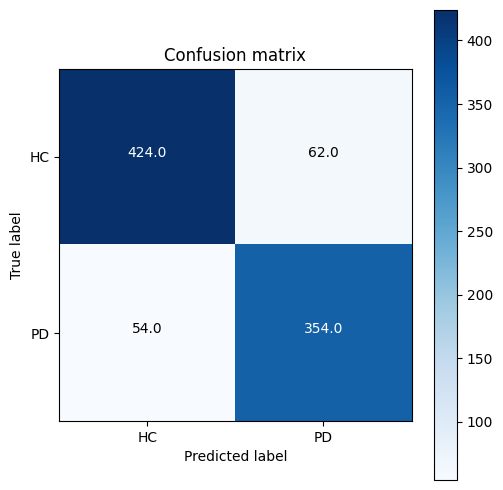

In [ ]:
# confusion matrix
confusion_mtx = np.array([[TN[-1], FP[-1]], [FN[-1], TP[-1]]])
print("confusion matrix=\n",confusion_mtx)
class_names=['HC','PD']
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(confusion_mtx, class_names)


# Filters' Visualization

In [ ]:
epoch=199
fold= 0

In [ ]:
# آزمایش و بررسیییییی
#a= CNN_net.conv[0].filters.detach().numpy()
file_path = '/content/drive/My Drive/COLAB/project/Network_weights/'+'filters_vals_fold'+str(fold)+'_'+str(epoch)+'.txt'
a=np.genfromtxt(file_path, delimiter=',')
# یکی از دو بخش بالا باید هش باشه/ تفاوت در نحوه خوانش وزن ها
x=np.linspace(0,0.5,257)
y=np.linspace(-256,256,1000)
cumulative = np.zeros([100,1000])
for i in range(100):
  plt.figure(1,figsize=(15,10))
  plt.grid(linestyle='--', linewidth=0.7)
  cumulative[i][:] = np.fft.fftshift(np.abs(np.fft.fft(a[i, :], 1000)))
  plt.plot(x,a[i,:])
  plt.figure(2,figsize=(15,10))
  plt.plot(y,np.fft.fftshift(np.abs(np.fft.fft(a[i, :], 1000))))
cumulative = np.mean(cumulative,axis=0)

plt.xlim([0,60])
plt.grid(linestyle='--', linewidth=0.7)
plt.show()

FileNotFoundError: ignored

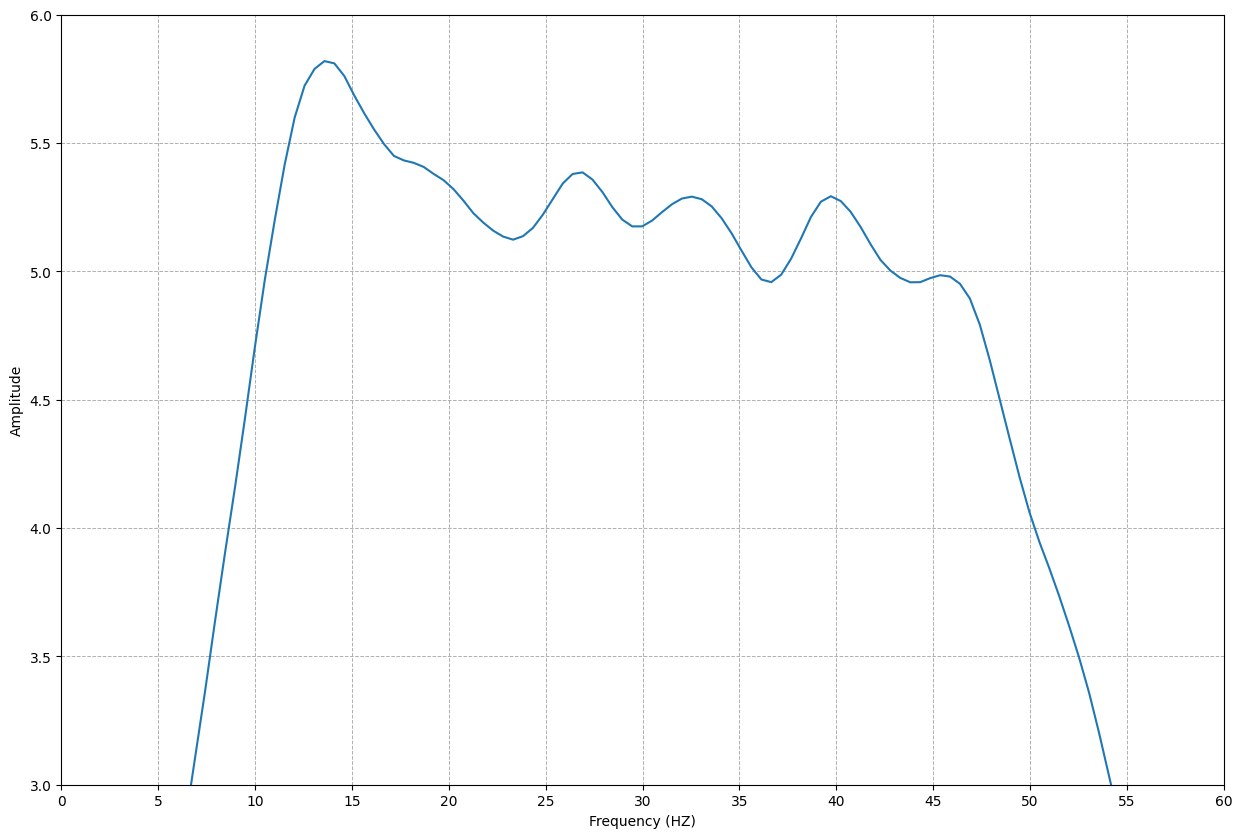

In [ ]:
#cumulative = np.mean(cumulative,axis=0)
plt.figure(1,figsize=(15,10))
plt.plot(y,cumulative)
plt.xticks(np.arange(0, max(y)+1, 5,))

plt.xlim([0,60])
plt.ylim([3,6])
plt.grid(linestyle='--', linewidth=0.7)
plt.xlabel('Frequency (HZ)')
plt.ylabel('Amplitude')
plt.show()

### PSD

Text(0, 0.5, 'PSD [dB/Hz]')

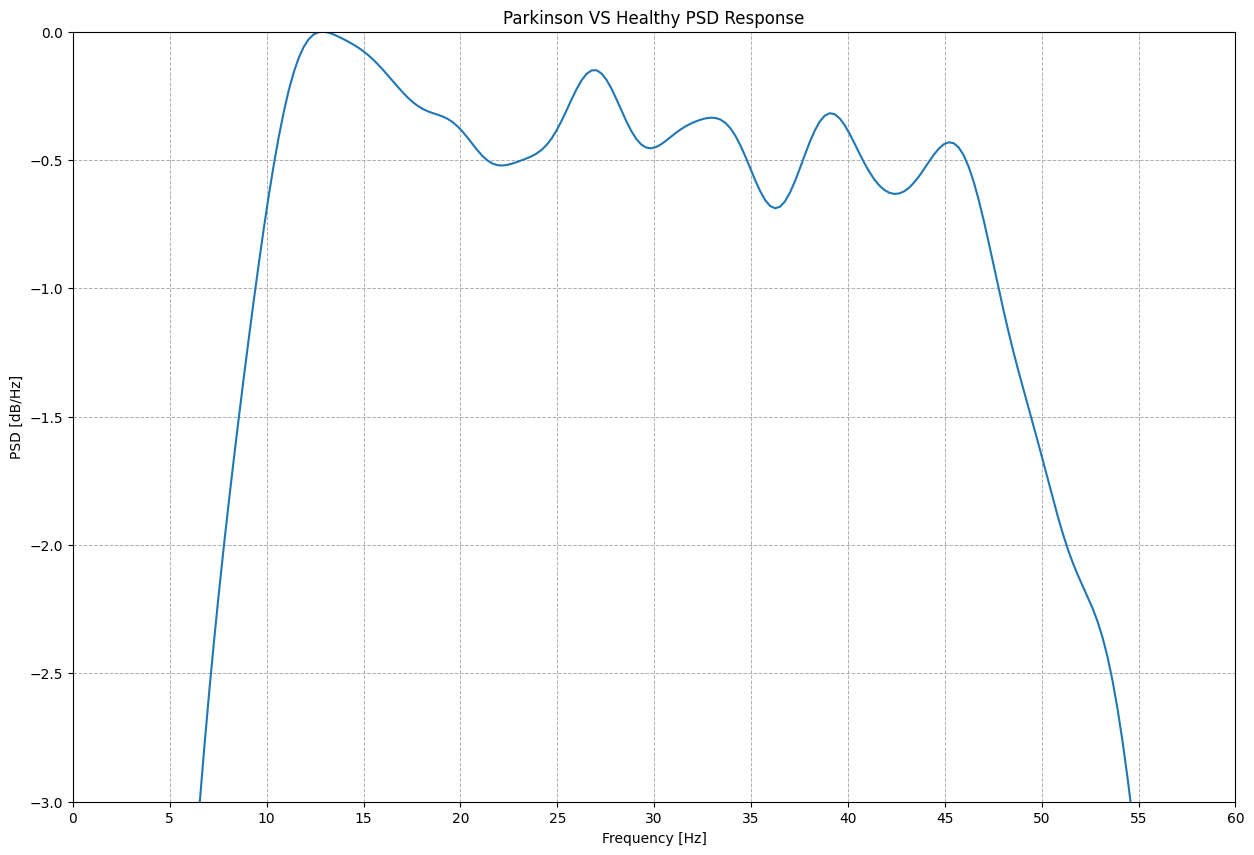

In [ ]:
# for calculation of PSD
d_size = 100 # number of filters که ما 100تا داریم
temp_val = np.zeros([d_size, 2000])
for p in range(d_size):
  temp_val[p][:]=np.fft.fftshift(np.multiply((1 / (512 * 1000)),(np.abs(np.fft.fft(a[p, :], 2000)) ** 2)))
#data(k,q,:)=mean(temp_val(:,1001:2000),1);
data = np.mean(temp_val,axis = 0)
z = np.linspace(-256,256,2000)# 256 is selected bc our fs is 512 which according to Nyquist, half freqs can be detected
plt.figure(1,figsize=(15,10))
plt.plot(z,10*np.log10(np.abs(data)/np.max(np.abs(data))))
plt.xticks(np.arange(0, max(y)+1, 5))
plt.grid(linestyle='--', linewidth=0.7)
plt.xlim([0,60])
#linspace(0,250,1000),10*log10(abs(data_sad(i,:))./max(abs(data_sad(i,:)))),'r','LineWidth',2);
plt.ylim([-3,0])
plt.title('Parkinson VS Healthy PSD Response')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD [dB/Hz]')

# for all folds

In [ ]:
epoch = 399
for f in range(10):
  file_path = '/content/drive/My Drive/COLAB/project/Network_weights/'+'filters_vals_fold'+str(f+1)+'_'+str(epoch)+'.txt'
  print('reading: ',f)
  globals()['Sinc_filts' %f] = np.genfromtxt(file_path, delimiter = ',')
  print('reading: ',f)

reading:  0


FileNotFoundError: ignored

In [ ]:

epoch = 400
for f in range(10):
  file_path = '/content/drive/My Drive/COLAB/project/Network_weights/'+'filters_vals_fold'+str(f)+'_'+str(epoch)+'.txt'
  globals()['Sinc_filts' %f] = np.genfromtxt(file_path, dilimiter = ',')
  print('reading: ',f)
a0=np.genfromtxt(file_path, delimiter=',')
address = f'/content/drive/My Drive/COLAB/project/dataset/hc_{number}_final.set'
file_name = f'hc_{a}'
globals()['hc%s' % a] = mne.io.read_raw_eeglab(address)

file_path = '/content/drive/My Drive/COLAB/project/Network_weights/'+'filters_vals_fold'+str(fold[1])+'_'+str(epoch)+'.txt'
a1=np.genfromtxt(file_path, delimiter=',')
file_path = '/content/drive/My Drive/COLAB/project/Network_weights/'+'filters_vals_fold'+str(fold[2])+'_'+str(epoch)+'.txt'
a2=np.genfromtxt(file_path, delimiter=',')
file_path = '/content/drive/My Drive/COLAB/project/Network_weights/'+'filters_vals_fold'+str(fold[3])+'_'+str(epoch)+'.txt'
a3=np.genfromtxt(file_path, delimiter=',')
file_path = '/content/drive/My Drive/COLAB/project/Network_weights/'+'filters_vals_fold'+str(fold[4])+'_'+str(epoch)+'.txt'
a4=np.genfromtxt(file_path, delimiter=',')
file_path = '/content/drive/My Drive/COLAB/project/Network_weights/'+'filters_vals_fold'+str(fold[0])+'_'+str(epoch)+'.txt'
a5=np.genfromtxt(file_path, delimiter=',')




x=np.linspace(0,0.5,257)
y=np.linspace(-256,256,1000)
cumulative = np.zeros([100,1000])
for i in range(100):
  plt.figure(1,figsize=(15,10))
  plt.grid(linestyle='--', linewidth=0.7)
  cumulative[i][:] = np.fft.fftshift(np.abs(np.fft.fft(a[i, :], 1000)))
  plt.plot(x,a[i,:])
  plt.figure(2,figsize=(15,10))
  plt.plot(y,np.fft.fftshift(np.abs(np.fft.fft(a[i, :], 1000))))
cumulative = np.mean(cumulative,axis=0)

plt.xlim([0,60])
plt.grid(linestyle='--', linewidth=0.7)
plt.show()

/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold0_400.txt
/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold1_400.txt
/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold2_400.txt
/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold3_400.txt
/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold4_400.txt
/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold5_400.txt
/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold6_400.txt
/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold7_400.txt
/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold8_400.txt
/content/drive/My Drive/COLAB/project/Network_weights/filters_vals_fold9_400.txt


FileNotFoundError: ignored